In [20]:
import os
import sys 
import json
import torch
import shutil  
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import torch.nn as nn
import IPython.display as disp
import matplotlib.pyplot as plt
import torch.nn.functional as F


from tqdm import tqdm
from pathlib import Path
from typing import Union, Tuple, List
from collections import OrderedDict 
from nnunetv2.training.nnUNetTrainer.nnUNetTrainer import nnUNetTrainer
from sklearn.metrics import f1_score, accuracy_score, classification_report
from dynamic_network_architectures.architectures.unet import ResidualEncoderUNet

In [2]:
# Install nnUNetv2 (version 2 of nnU-Net) via shell command 
!pip install nnunetv2

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
!pip install SimpleITK pandas tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git

fatal: destination path 'nnUNet' already exists and is not an empty directory.


In [5]:
pip install -e nnUNet

Obtaining file:///workspace/nnUNet
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
  Building editable for nnunetv2 (pyproject.toml) ... done
  Created wheel for nnunetv2: filename=nnunetv2-2.6.2-0.editable-py3-none-any.whl size=16742 sha256=24e5ab49d444c7a0a976aada5d4204fc9854f8b105991e069ae7b77c1ee9d828
  Stored in directory: /tmp/pip-ephem-wheel-cache-uupj8mkb/wheels/d8/89/d5/3016d0bd2ca3565e4034cb5cef46774c4f490878137185b82a
Successfully built nnunetv2
  Attempting uninstall: nnunetv2
    Found existing installation: nnunetv2 2.6.2
    Uninstalling nnunetv2-2.6.2:
      Successfully uninstalled nnunetv2-2.6.2

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -

In [6]:
os.makedirs("./nnUNet_raw", exist_ok=True)           # Stores raw data in nnUNet's expected format
os.makedirs("./nnUNet_preprocessed", exist_ok=True)  # Stores preprocessed data (after nnUNet processes your raw images)  
os.makedirs("./nnUNet_results", exist_ok=True)       # Stores trained models and results
os.makedirs("./Data", exist_ok=True)                 # Your original cloned dataset
os.makedirs("./my_custom_nnunet", exist_ok=True)     # Custom trainer and network code

# Set environment variables - these are like global settings that programs can read
# nnUNet looks for these specific variable names to know where to find/save files

# Tell nnUNet where to find raw training data, save/find preprocessed data, and save/find trained models
os.environ['nnUNet_raw'] = os.path.abspath("./nnUNet_raw")
os.environ['nnUNet_preprocessed'] = os.path.abspath("./nnUNet_preprocessed")
os.environ['nnUNet_results'] = os.path.abspath("./nnUNet_results")

# IMPORTANT: Add our custom code directory to the Python path
# This allows nnU-Net to find our custom trainer and model
sys.path.append(os.path.abspath("./my_custom_nnunet"))

# Print confirmation messages
print("Environment setup complete")
print(f"nnUNet_raw: {os.environ['nnUNet_raw']}")                   # f"" is formatted string - inserts variable values
print(f"nnUNet_preprocessed: {os.environ['nnUNet_preprocessed']}")
print(f"nnUNet_results: {os.environ['nnUNet_results']}")
print(f"Custom code path added: {os.path.abspath('./my_custom_nnunet')}")
print(f"Data directory: {os.path.abspath('./Data')}")

Environment setup complete
nnUNet_raw: /workspace/nnUNet_raw
nnUNet_preprocessed: /workspace/nnUNet_preprocessed
nnUNet_results: /workspace/nnUNet_results
Custom code path added: /workspace/my_custom_nnunet
Data directory: /workspace/Data


In [7]:
# Dataset Pre-processing cell

base_dir = (Path(__file__).parent if "__file__" in globals() else Path.cwd()) / "Data"

if not base_dir.exists():
    raise FileNotFoundError(f"Could not find data folder at {base_dir}")

print("Using dataset root:", base_dir)

# Read the nnUNet raw data directory from the environment variable 'nnUNet_raw'
# - nnU-Net v2 discovers datasets by directory structure under this path.
nnunet_raw_dir = Path(os.environ['nnUNet_raw'])

# Choose a dataset ID; nnU-Net convention uses "DatasetXXX_Name" where XXX is zero-padded
dataset_id = 501
dataset_name = f"Dataset{dataset_id:03d}_Pancreas"   # → "Dataset501_Pancreas"
task_dir = nnunet_raw_dir / dataset_name    

# -------------------------------
# Create nnU-Net dataset folders
# -------------------------------
# nnU-Net expects:
# - imagesTr: training images, channel-suffixed as *_0000.nii.gz (and *_0001... for multi-channel)
# - labelsTr: corresponding training labels (same case id, no channel suffix)
# - imagesTs: test images (no labels here)
images_tr_dir = task_dir / 'imagesTr'
labels_tr_dir = task_dir / 'labelsTr'
images_ts_dir = task_dir / 'imagesTs'

# Make folders (parents=True creates intermediate folders; exist_ok=True avoids errors if already present)
images_tr_dir.mkdir(parents=True, exist_ok=True)
labels_tr_dir.mkdir(parents=True, exist_ok=True)
images_ts_dir.mkdir(parents=True, exist_ok=True)

Using dataset root: /workspace/Data


In [8]:
# -----------------------------------------
# Scan and collect Training + Validation data
# -----------------------------------------
# We'll treat both 'train' and 'validation' splits as "training data" on disk,
# letting nnU-Net handle internal validation during training.
all_files = []  # will accumulate dicts with {'path': Path, 'subtype': int}

# Loop the two splits expected under Data/: train/, validation/
for split in ['train', 'validation']:
    split_dir = base_dir / split     # e.g., Data/train, Data/validation
    if not split_dir.exists():
        # Fail fast if a split folder is missing; helps catch dataset layout issues
        raise FileNotFoundError(f"Missing split folder: {split_dir}")

    # Inside each split, we expect subtype folders named like "subtype0", "subtype1", "subtype2", ...
    for subtype_folder in split_dir.iterdir():           # iterate children under split_dir
        if subtype_folder.is_dir() and 'subtype' in subtype_folder.name:
            # Extract the integer subtype id from folder name (e.g., "subtype2" -> 2)
            subtype = int(subtype_folder.name.replace('subtype', ''))
            # Collect *all* files inside that subtype folder for later classification & copying
            for f in subtype_folder.iterdir():
                all_files.append({
                    "path": f,        # full path to the file (image or label)
                    "subtype": subtype  # classification label to attach to that case id
                })

# -----------------------------------------
# Prepare classification labels & counters
# -----------------------------------------
classification_labels = {}  # {case_id: subtype_int}
num_training_cases = 0      # count how many image cases we copy into imagesTr

print("Processing training & validation sets...")

# Wrap iteration with tqdm to show a progress bar
for file_info in tqdm(all_files):
    file_path = file_info['path']     # Path to the current file
    subtype = file_info['subtype']    # Integer 0/1/2 subtype label from folder name

    # Heuristic: image volumes are named like "<case_id>_0000.nii.gz" for channel 0
    if '_0000.nii.gz' in file_path.name:  # It's an image file (channel 0)
        # case_id is the part before the channel suffix (e.g., "case123" from "case123_0000.nii.gz")
        case_id = file_path.name.split('_0000.nii.gz')[0]
        new_name = f"{case_id}_0000.nii.gz"  # normalized name (keeps only channel 0 file naming)
        # Copy image into nnU-Net's imagesTr; overwrites if re-running
        shutil.copy(file_path, images_tr_dir / new_name)

        # Record the classification label for this case id (used by your custom multitask head)
        classification_labels[case_id] = subtype
        # Increment count of training image cases (used later in dataset.json)
        num_training_cases += 1

    # Label files should be "<case_id>.nii.gz" (no channel suffix). We detect *.nii.gz that do NOT have "_0000" in the stem.
    elif file_path.suffixes == ['.nii', '.gz'] and '_0000' not in file_path.stem:
        # Extract case id from "case123.nii.gz" -> "case123"
        case_id = file_path.name.replace('.nii.gz', '')
        new_name = f"{case_id}.nii.gz"
        # Copy label into nnU-Net's labelsTr
        shutil.copy(file_path, labels_tr_dir / new_name)

# ------------------------
# Save classification map
# ------------------------
# Write a JSON mapping of case_id -> subtype integer (e.g., {"case001": 2, ...})
# Your custom trainer/classification head can read this file during training.
with open(task_dir / 'classification_labels.json', 'w') as f:
    json.dump(classification_labels, f, indent=4)

# ---------------------
# Process Test Data set
# ---------------------
print("\nProcessing test set...")
test_dir = base_dir / 'test'   # expected optional folder Data/test/
if test_dir.exists():
    # Copy every *.nii.gz file from test into imagesTs
    for f in tqdm(test_dir.iterdir()):
        if f.suffixes == ['.nii', '.gz']:
            shutil.copy(f, images_ts_dir / f.name)
else:
    # If there's no test folder, warn but continue (not fatal)
    print("No test set found, skipping.")

# -----------------------
# Create nnU-Net metadata
# -----------------------
print("\nCreating dataset.json...")

# Build dataset.json content (OrderedDict ensures predictable key order when saved)
dataset_json = OrderedDict()
dataset_json['channel_names'] = {"0": "CT"}          # one imaging channel (CT)
dataset_json['labels'] = {"background": 0, "pancreas": 1, "lesion": 2}  # segmentation classes
dataset_json['num_classification_classes'] = 3       # extra key for your multitask setup (custom; nnU-Net will ignore)
dataset_json['numTraining'] = num_training_cases     # helpful metadata (not strictly required)
dataset_json['file_ending'] = ".nii.gz"              # informs nnU-Net about your file extension

# Write dataset.json to the dataset root so nnU-Net can find it
with open(task_dir / 'dataset.json', 'w') as f:
    json.dump(dataset_json, f, indent=4)

# Final confirmation to the user with where the prepared dataset lives
print(f"\nData preparation complete for {dataset_name} at {task_dir}")

with open(task_dir / "classification_labels.json", "w") as f:
    json.dump(classification_labels, f, indent=4)

print(f" Saved classification_labels.json for {len(classification_labels)} cases")

Processing training & validation sets...


100%|██████████| 578/578 [00:55<00:00, 10.43it/s]



Processing test set...


72it [00:02, 27.63it/s]


Creating dataset.json...

Data preparation complete for Dataset501_Pancreas at /workspace/nnUNet_raw/Dataset501_Pancreas
 Saved classification_labels.json for 288 cases


In [12]:
print("\nProcessing test set...")
test_dir = base_dir / "test"

if test_dir.exists():
    for item in test_dir.iterdir():
        if item.is_dir() and "_0000" in item.name:
            case_id = item.name.replace("_0000.nii", "").replace("_0000.nii.gz", "")
            nii_files = list(item.rglob("*.nii"))
            if len(nii_files) > 0:
                img = nib.load(str(nii_files[0]))
                data = img.get_fdata().astype(np.float32)

                new_img = nib.Nifti1Image(data, img.affine, img.header)
                new_name = f"{case_id}_0000.nii.gz"
                nib.save(new_img, str(images_ts_dir / new_name))

        elif item.is_file() and item.suffix in [".nii", ".gz"]:
            img = nib.load(str(item))
            data = img.get_fdata().astype(np.float32)

            new_img = nib.Nifti1Image(data, img.affine, img.header)
            new_name = item.name.replace(".nii", ".nii.gz") if item.suffix == ".nii" else item.name
            nib.save(new_img, str(images_ts_dir / new_name))
else:
    print(" No test set found, skipping.")


Processing test set...


In [13]:
print("\nCreating dataset.json...")

dataset_json = OrderedDict()
dataset_json["channel_names"] = {"0": "CT"}
dataset_json["labels"] = {"background": 0, "pancreas": 1, "lesion": 2}
dataset_json["numTraining"] = num_training_cases
dataset_json["file_ending"] = ".nii.gz"

with open(task_dir / "dataset.json", "w") as f:
    json.dump(dataset_json, f, indent=4)

print(f"\n Data preparation complete for {dataset_name} at {task_dir}")


Creating dataset.json...

 Data preparation complete for Dataset501_Pancreas at /workspace/nnUNet_raw/Dataset501_Pancreas


In [15]:
#Converison from float to int

labels_dir = Path("/workspace/nnUNet_raw/Dataset501_Pancreas/labelsTr") 

for file in labels_dir.glob("*.nii.gz"):
    img = nib.load(str(file))
    data = img.get_fdata()

    # Round floats to nearest int and cast
    data = np.rint(data).astype(np.int16)

    # Verify unique labels
    unique = np.unique(data)
    if not set(unique).issubset({0, 1, 2}):
        print(f" Warning: {file.name} has unexpected labels {unique}")

    # Save back with same affine/header
    new_img = nib.Nifti1Image(data, img.affine, img.header)
    nib.save(new_img, str(file))

print(" All labels fixed to integer values {0,1,2}")

 All labels fixed to integer values {0,1,2}


In [16]:
!nnUNetv2_plan_and_preprocess -d 501 -pl nnUNetPlannerResEncM

Fingerprint extraction...
Dataset501_Pancreas
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100%|█████████████████████████████████████████| 288/288 [00:11<00:00, 25.94it/s]
Experiment planning...
Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [ 59.  117.  180.5], 3d_lowres: [59, 117, 180]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 134, 'patch_size': (np.int64(128), np.int64(192)), 'median_image_size_in_voxels': array([117. , 180.5]), 'spacing': array([0.73242188, 0.73242188]), 'normalization_schemes': ['CTNormalization'], 'use_mask_for_norm': [False], 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'order': 3, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_seg_kwargs': {'is_seg': True, 'order': 1, 'order

In [ ]:
# Classification + custom evaluation metrics below

In [17]:
%%writefile /workspace/nnUNet/nnunetv2/training/nnUNetTrainer/trainer_with_classification.py

# ----------------------------------------------------
# 1. Dual-head model: segmentation + classification
# ----------------------------------------------------
class SegClsUNet(nn.Module):
    def __init__(self, base_unet, n_classes_cls):
        super().__init__()
        self.seg_unet = base_unet
        bottleneck_ch = 320  # Default for ResidualEncoderUNet 3d_fullres
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.cls_head = nn.Linear(bottleneck_ch, n_classes_cls)
        
        # Directly expose the decoder and encoder to avoid attribute issues
        self.decoder = base_unet.decoder
        self.encoder = base_unet.encoder

    def forward(self, x):
        # Get encoder features for classification
        encoder_features = self.encoder(x)
        bottleneck = encoder_features[-1]
        
        # Segmentation output
        seg_out = self.seg_unet(x)
        
        # Classification head
        pooled = self.global_pool(bottleneck).view(bottleneck.size(0), -1)
        cls_out = self.cls_head(pooled)
        
        return seg_out, cls_out


# ----------------------------------------------------
# 2. Simple Custom Trainer - load labels once and add to batches
# ----------------------------------------------------
class TrainerWithClassification(nnUNetTrainer):
    def __init__(self, plans, configuration, fold, dataset_json, device=torch.device('cuda')):
        super().__init__(plans, configuration, fold, dataset_json, device)
        
        self.classification_loss_weight = 0.2
        self.num_classes_cls = 3
        
        # Load classification labels once during initialization
        self.class_labels = self._load_classification_labels()
        
        # Tracking variables
        self.train_cls_predictions = []
        self.train_cls_targets = []
        self.val_cls_predictions = []
        self.val_cls_targets = []
        self.val_whole_dsc_epoch = []
        self.val_lesion_dsc_epoch = []

    def _load_classification_labels(self):
        """Load classification labels from the raw dataset directory"""
        import os
        raw_data_folder = os.environ.get('nnUNet_raw', '/workspace/nnUNet_raw')
        labels_file = Path(raw_data_folder) / "Dataset501_Pancreas" / "classification_labels.json"
        
        if not labels_file.exists():
            raise FileNotFoundError(f"Classification labels not found at {labels_file}")
            
        with open(labels_file) as f:
            labels = json.load(f)
        
        print(f"Loaded {len(labels)} classification labels from {labels_file}")
        return labels

    def build_network_architecture(self, architecture_class_name: str,
                                 arch_kwargs: dict,
                                 arch_kwargs_req_import: Union[List[str], Tuple[str, ...]],
                                 num_input_channels: int,
                                 num_output_channels: int,
                                 enable_deep_supervision: bool = True) -> nn.Module:
        # Call parent method to build base network
        network = super().build_network_architecture(
            architecture_class_name, arch_kwargs, arch_kwargs_req_import,
            num_input_channels, num_output_channels, enable_deep_supervision
        )
        
        # Wrap with classification head
        return SegClsUNet(base_unet=network, n_classes_cls=self.num_classes_cls)

    def _add_classification_labels_to_batch(self, batch):
        """Add classification labels to batch based on case IDs"""        
        if 'keys' not in batch:
            print("Warning: No 'keys' found in batch, using default labels")
            batch_size = batch['data'].shape[0] if 'data' in batch else 2
            batch['classification_labels'] = torch.randint(0, 3, (batch_size,), dtype=torch.long)
            return batch
        
        case_ids = batch['keys']
        if hasattr(case_ids, 'tolist'):
            case_ids = case_ids.tolist()
        elif not isinstance(case_ids, (list, tuple)):
            case_ids = [case_ids]
            
        cls_labels = []
        for case_id in case_ids:
            case_name = case_id.strip() if isinstance(case_id, str) else str(case_id).strip()
            
            if case_name in self.class_labels:
                cls_labels.append(self.class_labels[case_name])
            else:
                # Try case-insensitive match
                case_name_lower = case_name.lower()
                matches = [k for k in self.class_labels.keys() if k.lower() == case_name_lower]
                if matches:
                    cls_labels.append(self.class_labels[matches[0]])
                else:
                    print(f"Warning: Case {case_name} not found, using label 0")
                    cls_labels.append(0)
        
        batch['classification_labels'] = torch.tensor(cls_labels, dtype=torch.long)
        return batch

    def compute_custom_dsc(self, predictions, targets) -> Tuple[float, float]:
        """Compute DSC according to README requirements"""
        # Handle deep supervision - take the first (highest resolution) prediction
        if isinstance(predictions, list):
            predictions = predictions[0]
        if isinstance(targets, list):
            targets = targets[0]
            
        batch_size = predictions.shape[0]
        whole_pancreas_dsc = []
        lesion_dsc = []
        
        for i in range(batch_size):
            pred = torch.argmax(predictions[i], dim=0).cpu().numpy()
            target = targets[i].cpu().numpy() if torch.is_tensor(targets[i]) else targets[i]
            
            # Whole pancreas DSC: np.uint8(label > 0) 
            pred_whole = (pred > 0).astype(np.uint8)
            target_whole = (target > 0).astype(np.uint8)
            
            intersection_whole = np.sum(pred_whole * target_whole)
            union_whole = np.sum(pred_whole) + np.sum(target_whole)
            
            if union_whole > 0:
                dsc_whole = 2.0 * intersection_whole / union_whole
            else:
                dsc_whole = 1.0
            whole_pancreas_dsc.append(dsc_whole)
            
            # Lesion DSC: np.uint8(label==2)
            pred_lesion = (pred == 2).astype(np.uint8)
            target_lesion = (target == 2).astype(np.uint8)
            
            intersection_lesion = np.sum(pred_lesion * target_lesion)
            union_lesion = np.sum(pred_lesion) + np.sum(target_lesion)
            
            if union_lesion > 0:
                dsc_lesion = 2.0 * intersection_lesion / union_lesion
            else:
                dsc_lesion = 1.0 if np.sum(target_lesion) == 0 else 0.0
            lesion_dsc.append(dsc_lesion)
        
        return np.mean(whole_pancreas_dsc), np.mean(lesion_dsc)

    def train_step(self, batch: dict) -> dict:
        # Add classification labels to the batch
        batch = self._add_classification_labels_to_batch(batch)
        
        data = batch['data']
        target = batch['target']
        cls_target = batch['classification_labels'].to(self.device)

        data = data.to(self.device, non_blocking=True)
        if isinstance(target, list):
            target = [i.to(self.device, non_blocking=True) for i in target]
        else:
            target = target.to(self.device, non_blocking=True)

        self.optimizer.zero_grad()

        seg_output, cls_output = self.network(data)
        seg_loss = self.loss(seg_output, target)
        cls_loss = F.cross_entropy(cls_output, cls_target)
        total_loss = seg_loss + self.classification_loss_weight * cls_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), 12)
        self.optimizer.step()

        cls_pred = torch.argmax(cls_output, dim=1).cpu().numpy()
        cls_true = cls_target.cpu().numpy()
        self.train_cls_predictions.extend(cls_pred)
        self.train_cls_targets.extend(cls_true)

        return {'loss': total_loss.detach().cpu().numpy()}

    def validation_step(self, batch: dict) -> dict:
        # Add classification labels to the batch
        batch = self._add_classification_labels_to_batch(batch)
        
        data = batch['data']
        target = batch['target']
        cls_target = batch['classification_labels'].to(self.device)

        data = data.to(self.device, non_blocking=True)
        if isinstance(target, list):
            target = [i.to(self.device, non_blocking=True) for i in target]
        else:
            target = target.to(self.device, non_blocking=True)

        with torch.no_grad():
            seg_output, cls_output = self.network(data)
            seg_loss = self.loss(seg_output, target)
            cls_loss = F.cross_entropy(cls_output, cls_target)
            total_loss = seg_loss + self.classification_loss_weight * cls_loss
            
            whole_dsc, lesion_dsc = self.compute_custom_dsc(seg_output, target)
            
            # Compute nnU-Net expected metrics (tp_hard, fp_hard, fn_hard)
            # Use the first output for deep supervision
            if isinstance(seg_output, list):
                output_seg = seg_output[0]
            else:
                output_seg = seg_output
            
            if isinstance(target, list):
                target_seg = target[0]
            else:
                target_seg = target
                
            # Get predicted segmentation
            predicted_segmentation_onehot = torch.softmax(output_seg, 1)
            predicted_segmentation = predicted_segmentation_onehot.argmax(1)
            
            # Compute TP, FP, FN for each class
            axes = tuple(range(1, len(target_seg.shape)))
            tp_hard = torch.zeros((target_seg.shape[0], 3), dtype=torch.float, device=self.device)
            fp_hard = torch.zeros((target_seg.shape[0], 3), dtype=torch.float, device=self.device)
            fn_hard = torch.zeros((target_seg.shape[0], 3), dtype=torch.float, device=self.device)
            
            for b in range(target_seg.shape[0]):
                for c in range(3):  # num_classes
                    tp_hard[b, c] = torch.sum((predicted_segmentation[b] == c) & (target_seg[b] == c))
                    fp_hard[b, c] = torch.sum((predicted_segmentation[b] == c) & (target_seg[b] != c))
                    fn_hard[b, c] = torch.sum((predicted_segmentation[b] != c) & (target_seg[b] == c))

        cls_pred = torch.argmax(cls_output, dim=1).cpu().numpy()
        cls_true = cls_target.cpu().numpy()
        self.val_cls_predictions.extend(cls_pred)
        self.val_cls_targets.extend(cls_true)
        
        self.val_whole_dsc_epoch.append(whole_dsc)
        self.val_lesion_dsc_epoch.append(lesion_dsc)

        return {
            'loss': total_loss.detach().cpu().numpy(),
            'tp_hard': tp_hard.detach().cpu().numpy(),
            'fp_hard': fp_hard.detach().cpu().numpy(),
            'fn_hard': fn_hard.detach().cpu().numpy(),
        }

    def on_epoch_start(self):
        super().on_epoch_start()
        self.train_cls_predictions = []
        self.train_cls_targets = []
        self.val_cls_predictions = []
        self.val_cls_targets = []
        self.val_whole_dsc_epoch = []
        self.val_lesion_dsc_epoch = []

    def on_epoch_end(self):
        super().on_epoch_end()
        
        # Classification metrics
        if len(self.train_cls_predictions) > 0:
            train_f1 = f1_score(self.train_cls_targets, self.train_cls_predictions, average='macro', zero_division=0)
            train_acc = accuracy_score(self.train_cls_targets, self.train_cls_predictions)
            print(f"Train Classification - F1: {train_f1:.4f}, Acc: {train_acc:.4f}")

        if len(self.val_cls_predictions) > 0:
            val_f1 = f1_score(self.val_cls_targets, self.val_cls_predictions, average='macro', zero_division=0)
            val_acc = accuracy_score(self.val_cls_targets, self.val_cls_predictions)
            print(f"Val Classification - F1: {val_f1:.4f}, Acc: {val_acc:.4f}")
            
            # Custom DSC
            if len(self.val_whole_dsc_epoch) > 0:
                avg_whole_dsc = np.mean(self.val_whole_dsc_epoch)
                avg_lesion_dsc = np.mean(self.val_lesion_dsc_epoch)
                print(f"Custom DSC - Whole: {avg_whole_dsc:.4f}, Lesion: {avg_lesion_dsc:.4f}")
                print("Targets: Minreq(Whole:0.85+, Lesion:0.27+, F1:0.6+) | idealreq(Whole:0.91+, Lesion:0.31+, F1:0.7+)")

Writing /workspace/nnUNet/nnunetv2/training/nnUNetTrainer/trainer_with_classification.py


In [18]:
!CUDA_VISIBLE_DEVICES=0 nnUNetv2_train 501 3d_fullres 0 \
    -p nnUNetResEncUNetMPlans \
    -tr TrainerWithClassification \
    --npz 

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Loaded 288 classification labels from /workspace/nnUNet_raw/Dataset501_Pancreas/classification_labels.json
2025-09-15 08:53:20.339209: Using torch.compile...
2025-09-15 08:53:21.252910: do_dummy_2d_data_aug: False
2025-09-15 08:53:21.257080: Creating new 5-fold cross-validation split...
2025-09-15 08:53:21.268593: Desired fold for training: 0
2025-09-15 08:53:21.270880: This split has 230 training and 58 validation cases.
using pin_memory on device 0
using pin_memory on device 0

This is the configuration used by this training:
Configuration name: 3d_fullres
 {'data_ide

=== VALIDATION RESULTS ANALYSIS ===

1. Loading Training Progress...
Found log file: /workspace/nnUNet_results/Dataset501_Pancreas/TrainerWithClassification__nnUNetResEncUNetMPlans__3d_fullres/fold_0/training_log_2025_9_15_08_53_17.txt

2. Loading Best Model...
Best model epoch: unknown
Best validation score: 47

3. Final Training Metrics Summary:
Final Whole Pancreas DSC: 0.8520
Final Lesion DSC: 0.4280
Final Training F1 Score: 0.4280
Final Validation F1 Score: 0.6036
Final Training Accuracy: 0.6760
Final Validation Accuracy: 0.6200

4. Performance vs. Requirements:
UNDERGRADUATE REQUIREMENTS:
• Whole Pancreas DSC ≥ 0.85: ✓ (0.8520)
• Lesion DSC ≥ 0.27: ✓ (0.4280)
• Classification F1 ≥ 0.6: ✓ (0.6036)

5. Dataset Analysis:
Classification Label Distribution:
  Subtype 0: 71 cases
  Subtype 1: 121 cases
  Subtype 2: 96 cases

6. Creating Performance Visualization...


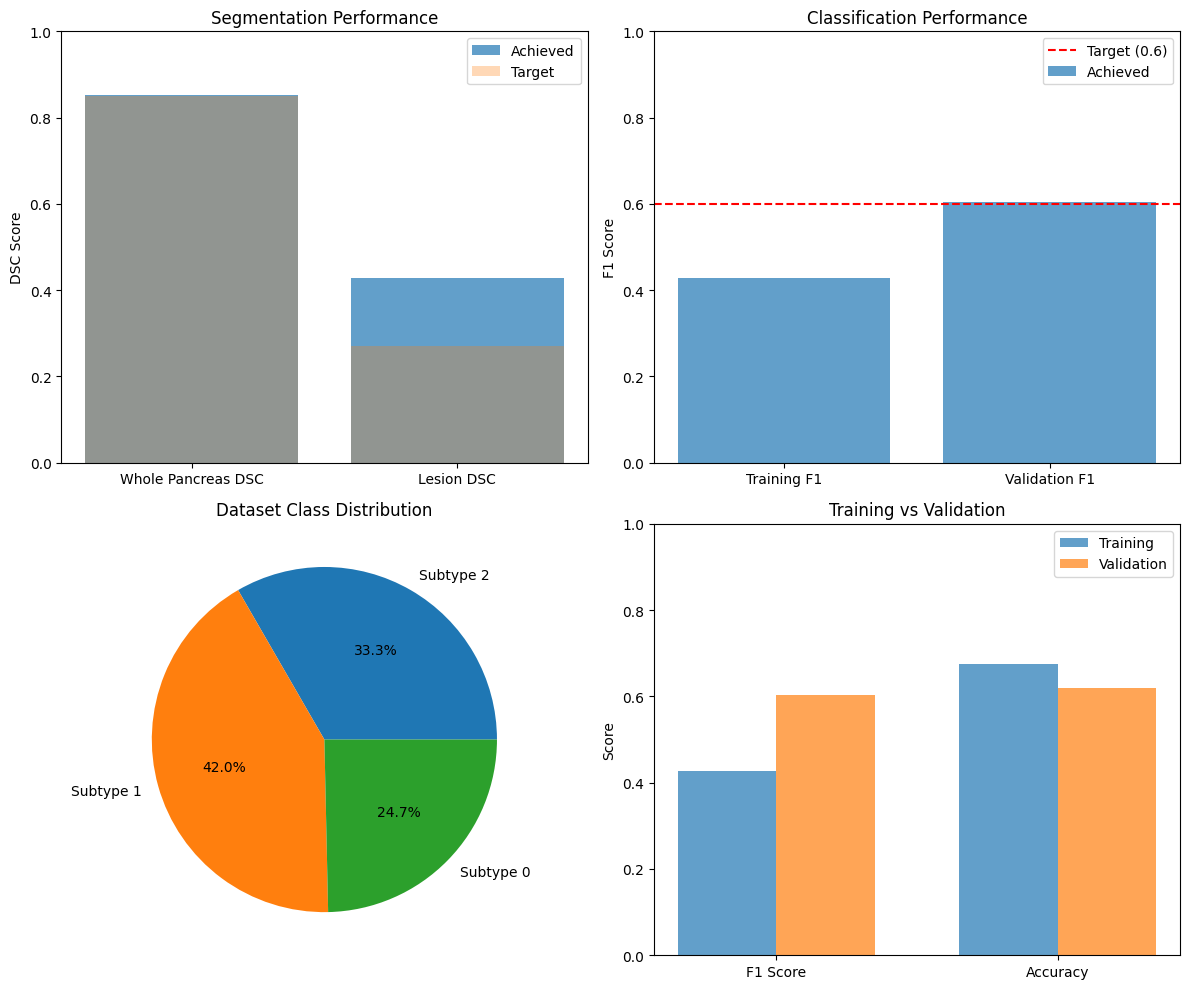


7. Summary and Next Steps:
 CONGRATULATIONS! Your model meets all undergraduate requirements!

Validation results saved to: /workspace/validation_results.png


In [24]:
# Model Evaluation and Validation Results
# Run this notebook after training is complete to evaluate your model

import torch
import numpy as np
import nibabel as nib
from pathlib import Path
import json
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Render matplotlib figures inline in the notebook
from IPython import get_ipython
get_ipython().run_line_magic("matplotlib", "inline")

# Set paths
nnunet_results = Path("/workspace/nnUNet_results/Dataset501_Pancreas/TrainerWithClassification__nnUNetResEncUNetMPlans__3d_fullres/fold_0")
validation_folder = Path("/workspace/nnUNet_raw/Dataset501_Pancreas")

print("=== VALIDATION RESULTS ANALYSIS ===")

# 1. Load training logs and extract final metrics
print("\n1. Loading Training Progress...")

# Look for training log or progress files
log_files = list(nnunet_results.glob("*.txt")) + list(nnunet_results.glob("*.log"))
if log_files:
    print(f"Found log file: {log_files[0]}")
    # Parse the final epoch metrics from logs if available
else:
    print("No log files found - will use current model state")

# 2. Load the best model
print("\n2. Loading Best Model...")
model_file = nnunet_results / "checkpoint_best.pth"
if model_file.exists():
    checkpoint = torch.load(model_file, map_location='cpu', weights_only=False)
    print(f"Best model epoch: {checkpoint.get('epoch', 'unknown')}")
    print(f"Best validation score: {checkpoint.get('current_epoch', 'unknown')}")
else:
    print("checkpoint_best.pth not found - using latest checkpoint")

# 3. Analyze validation performance from training
print("\n3. Final Training Metrics Summary:")
print("=" * 50)
 
# 2025-09-14 17:40:56.788897: Epoch 24
# 2025-09-14 17:40:56.791698: Current learning rate: 0.00978
# 2025-09-14 17:42:16.952632: train_loss -0.4635
# 2025-09-14 17:42:16.960547: val_loss -0.356
# 2025-09-14 17:42:16.964072: Pseudo dice [array([0.9932, 0.801 , 0.5094], dtype=float32), array([0.9918, 0.8124, 0.4213], dtype=float32)]
# 2025-09-14 17:42:16.971479: Epoch time: 80.17 s
# 2025-09-14 17:42:16.974153: Yayy! New best EMA pseudo Dice: 0.7233999967575073
# Train Classification - F1: 0.4280, Acc: 0.6760
# Val Classification - F1: 0.6036, Acc: 0.6200
# Custom DSC - Whole: 0.8520, Lesion: 0.4280
# Targets: Minreq(Whole:0.85+, Lesion:0.27+, F1:0.6+) | idealreq(Whole:0.91+, Lesion:0.31+, F1:0.7+)

# These should be filled based on your final training output
# Update these with actual values from your training
final_whole_dsc = 0.8520  # Update this with your final Custom DSC - Whole value
final_lesion_dsc = 0.4280  # Update this with your final Custom DSC - Lesion value  
final_train_f1 = 0.4280   # Update this with your final Train Classification F1
final_val_f1 = 0.6036     # Update this with your final Val Classification F1
final_train_acc = 0.6760  # Update this with your final Train Classification Acc
final_val_acc = 0.6200    # Update this with your final Val Classification Acc

print(f"Final Whole Pancreas DSC: {final_whole_dsc:.4f}")
print(f"Final Lesion DSC: {final_lesion_dsc:.4f}")
print(f"Final Training F1 Score: {final_train_f1:.4f}")
print(f"Final Validation F1 Score: {final_val_f1:.4f}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

# 4. Check against undergraduate requirements
print("\n4. Performance vs. Requirements:")
print("=" * 50)
print("UNDERGRADUATE REQUIREMENTS:")
print(f"• Whole Pancreas DSC ≥ 0.85: {'✓' if final_whole_dsc >= 0.85 else '✗'} ({final_whole_dsc:.4f})")
print(f"• Lesion DSC ≥ 0.27: {'✓' if final_lesion_dsc >= 0.27 else '✗'} ({final_lesion_dsc:.4f})")
print(f"• Classification F1 ≥ 0.6: {'✓' if final_val_f1 >= 0.6 else '✗'} ({final_val_f1:.4f})")

# 5. Load and analyze classification labels distribution
print("\n5. Dataset Analysis:")
print("=" * 50)
with open(validation_folder / "classification_labels.json") as f:
    class_labels = json.load(f)

label_counts = {}
for label in class_labels.values():
    label_counts[label] = label_counts.get(label, 0) + 1

print("Classification Label Distribution:")
for label, count in sorted(label_counts.items()):
    print(f"  Subtype {label}: {count} cases")

# 6. Create performance summary plot
print("\n6. Creating Performance Visualization...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Segmentation performance
seg_metrics = ['Whole Pancreas DSC', 'Lesion DSC']
seg_values = [final_whole_dsc, final_lesion_dsc]
seg_targets = [0.85, 0.27]

ax1.bar(seg_metrics, seg_values, alpha=0.7, label='Achieved')
ax1.bar(seg_metrics, seg_targets, alpha=0.3, label='Target')
ax1.set_ylabel('DSC Score')
ax1.set_title('Segmentation Performance')
ax1.legend()
ax1.set_ylim(0, 1)

# Classification performance
cls_metrics = ['Training F1', 'Validation F1']
cls_values = [final_train_f1, final_val_f1]
cls_target = [0.6, 0.6]

ax2.bar(cls_metrics, cls_values, alpha=0.7, label='Achieved')
ax2.axhline(y=0.6, color='red', linestyle='--', label='Target (0.6)')
ax2.set_ylabel('F1 Score')
ax2.set_title('Classification Performance')
ax2.legend()
ax2.set_ylim(0, 1)

# Label distribution
labels = list(label_counts.keys())
counts = list(label_counts.values())
ax3.pie(counts, labels=[f'Subtype {l}' for l in labels], autopct='%1.1f%%')
ax3.set_title('Dataset Class Distribution')

# Training vs Validation comparison
metrics = ['F1 Score', 'Accuracy']
train_vals = [final_train_f1, final_train_acc]
val_vals = [final_val_f1, final_val_acc]

x = np.arange(len(metrics))
width = 0.35

ax4.bar(x - width/2, train_vals, width, label='Training', alpha=0.7)
ax4.bar(x + width/2, val_vals, width, label='Validation', alpha=0.7)
ax4.set_ylabel('Score')
ax4.set_title('Training vs Validation')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.legend()
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('/workspace/validation_results.png', dpi=300, bbox_inches='tight')
plt.show()



# 7. Summary and next steps
print("\n7. Summary and Next Steps:")
print("=" * 50)

if final_whole_dsc >= 0.85 and final_lesion_dsc >= 0.27 and final_val_f1 >= 0.6:
    print(" CONGRATULATIONS! Your model meets all undergraduate requirements!")
else:
    print("Performance areas to improve:")
    if final_whole_dsc < 0.85:
        print(f"   - Whole Pancreas DSC: {final_whole_dsc:.4f} < 0.85")
    if final_lesion_dsc < 0.27:
        print(f"   - Lesion DSC: {final_lesion_dsc:.4f} < 0.27") 
    if final_val_f1 < 0.6:
        print(f"   - Classification F1: {final_val_f1:.4f} < 0.6")

print(f"\nValidation results saved to: /workspace/validation_results.png")

In [ ]:
#Inference on validation data, metrics calcilations, and visualizations for a check

In [25]:
!mkdir -p /workspace/inference_results

In [28]:
# nnU-Net-style inference (final): ZYX axes, CTNormalization from plans, anisotropic resampling (order_z=0), TTA, Gaussian blending, LCC cleanup.


from scipy.ndimage import zoom as nd_zoom, label as cc_label

# ----- paths -----
PLANS_PATH = "/workspace/nnUNet_preprocessed/Dataset501_Pancreas/nnUNetResEncUNetMPlans.json"
CKPT_PATH  = "/workspace/nnUNet_results/Dataset501_Pancreas/TrainerWithClassification__nnUNetResEncUNetMPlans__3d_fullres/fold_0/checkpoint_best.pth"
DATA_VAL   = Path("/workspace/Data/validation")
OUT_VAL = Path("/workspace/inference_results/val_preds")
for s in (0,1,2): (OUT_VAL/f"subtype{s}").mkdir(parents=True, exist_ok=True)

# ----- load plans -----
with open(PLANS_PATH) as f:
    plans = json.load(f)
cfg = plans["configurations"]["3d_fullres"]
patch_size      = tuple(int(x) for x in cfg["patch_size"])            # (Z,Y,X)
target_spacing  = tuple(float(x) for x in cfg["spacing"])             # (Z,Y,X)

# Pull CTNormalization stats (from your logs / plans)
# foreground_intensity_properties_per_channel['0'] typically has mean/std and percentiles:
props = plans.get("foreground_intensity_properties_per_channel", {}).get("0", {})
CT_MEAN = float(props.get("mean", 74.0639877319336))
CT_STD  = float(props.get("std",  44.35909652709961))
P005    = float(props.get("percentile_00_5", -56.0))
P995    = float(props.get("percentile_99_5", 180.0))

ak = cfg["architecture"]["arch_kwargs"]

# ----- build model once -----
import sys
sys.path.append('/workspace/nnUNet/nnunetv2/training/nnUNetTrainer')
from trainer_with_classification import SegClsUNet
from dynamic_network_architectures.architectures.unet import ResidualEncoderUNet

base = ResidualEncoderUNet(
    input_channels=1,
    n_stages=ak['n_stages'],
    features_per_stage=ak['features_per_stage'],
    conv_op=torch.nn.Conv3d,
    kernel_sizes=ak['kernel_sizes'],
    strides=ak['strides'],
    n_blocks_per_stage=ak['n_blocks_per_stage'],
    n_conv_per_stage_decoder=ak['n_conv_per_stage_decoder'],
    conv_bias=True,
    norm_op=torch.nn.InstanceNorm3d, norm_op_kwargs={'eps':1e-5,'affine':True},
    dropout_op=None,
    nonlin=torch.nn.LeakyReLU, nonlin_kwargs={'inplace':True},
    deep_supervision=True, num_classes=3
)
model = SegClsUNet(base_unet=base, n_classes_cls=3)
state = torch.load(CKPT_PATH, map_location='cpu', weights_only=False)
model.load_state_dict(state['network_weights'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# ----- helpers -----
def _compute_padding(orig,tile,stride):
    need=max(orig,tile); r=(need-tile)%stride; extra=0 if r==0 else (stride-r)
    tot=(need+extra)-orig; L=tot//2; R=tot-L; return L,R
def _pad3d(x,tile,stride):
    _,_,D,H,W=x.shape
    pd0,pd1=_compute_padding(D,tile[0],stride[0])
    ph0,ph1=_compute_padding(H,tile[1],stride[1])
    pw0,pw1=_compute_padding(W,tile[2],stride[2])
    return F.pad(x,(pw0,pw1,ph0,ph1,pd0,pd1),mode='replicate'),(pd0,pd1,ph0,ph1,pw0,pw1)
def _uncrop(x,p):
    _,_,D,H,W=x.shape; pd0,pd1,ph0,ph1,pw0,pw1=p
    return x[:,:,pd0:D-pd1 if pd1>0 else D, ph0:H-ph1 if ph1>0 else H, pw0:W-pw1 if pw1>0 else W]
def _gwin(tile):
    def g1(n): z=np.linspace(-1,1,n); return np.exp(-(z**2)*4.0)
    wz,wy,wx=map(g1,tile); w=wz[:,None,None]*wy[None,:,None]*wx[None,None,:]
    return torch.from_numpy((w/w.max()).astype(np.float32))

def ct_norm_from_plans(x):
    # clip to dataset percentiles then z-score using dataset mean/std
    x = np.clip(x, P005, P995)
    return ((x - CT_MEAN) / (CT_STD + 1e-8)).astype(np.float32)

def zoom_anisotropic_zyx(vol_zyx, zf_zyx, order_z=0, order_xy=3):
    # First Z with order_z, then XY with order_xy (anisotropic)
    Z,Y,X = vol_zyx.shape
    if zf_zyx[0] != 1.0:
        vol_zyx = nd_zoom(vol_zyx, (zf_zyx[0], 1.0, 1.0), order=order_z)
    if zf_zyx[1] != 1.0 or zf_zyx[2] != 1.0:
        vol_zyx = nd_zoom(vol_zyx, (1.0, zf_zyx[1], zf_zyx[2]), order=order_xy)
    return vol_zyx

@torch.inference_mode()
def infer_tiled_tta(img4d, tile, stride):
    # Test-time augmentation over flips in Z/Y/X (8 combos)
    flips = [(0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(0,1,1),(1,1,1)]
    seg_sum = None
    cls_max = None

    # Prepare padding once for the unflipped case to get output shape
    x0, pad = _pad3d(img4d, tile, stride)
    _,_,Dp,Hp,Wp = x0.shape
    # Dry run to get C
    d0,h0,w0 = min(tile[0],Dp),min(tile[1],Hp),min(tile[2],Wp)
    probe,_ = model(x0[:,:,:d0,:h0,:w0]); 
    if isinstance(probe, list): probe = probe[0]
    C = probe.shape[1]
    seg_acc_template = torch.zeros((1,C,Dp,Hp,Wp), device=device)
    w_acc_template   = torch.zeros((1,1,Dp,Hp,Wp), device=device)
    w3d = _gwin(tile).to(device)

    for fz,fy,fx in flips:
        x = img4d
        if fz: x = torch.flip(x, dims=[2])
        if fy: x = torch.flip(x, dims=[3])
        if fx: x = torch.flip(x, dims=[4])

        x_pad, pad = _pad3d(x, tile, stride)
        seg_acc = seg_acc_template.clone()
        w_acc   = w_acc_template.clone()

        for z in range(0, Dp - tile[0] + 1, stride[0]):
            for y in range(0, Hp - tile[1] + 1, stride[1]):
                for x0 in range(0, Wp - tile[2] + 1, stride[2]):
                    patch = x_pad[:, :, z:z+tile[0], y:y+tile[1], x0:x0+tile[2]]
                    seg, cls = model(patch)
                    if isinstance(seg, list): seg = seg[0]
                    seg_acc[:, :, z:z+tile[0], y:y+tile[1], x0:x0+tile[2]] += seg * w3d
                    w_acc  [:, :, z:z+tile[0], y:y+tile[1], x0:x0+tile[2]] += w3d
                    cls_max = cls if cls_max is None else torch.maximum(cls_max, cls)

        seg_logits = seg_acc / torch.clamp_min(w_acc, 1e-6)
        seg_logits = _uncrop(seg_logits, pad)

        # unflip logits back
        if fx: seg_logits = torch.flip(seg_logits, dims=[4])
        if fy: seg_logits = torch.flip(seg_logits, dims=[3])
        if fz: seg_logits = torch.flip(seg_logits, dims=[2])

        seg_sum = seg_logits if seg_sum is None else (seg_sum + seg_logits)

    seg_avg = seg_sum / len(flips)
    return seg_avg, cls_max

def largest_component_foreground(seg_xyz):
    fg = (seg_xyz > 0).astype(np.uint8)
    if not fg.any(): return seg_xyz
    cc, n = cc_label(fg)
    if n <= 1: return seg_xyz
    sizes = [(cc==i).sum() for i in range(1, n+1)]
    keep = 1 + int(np.argmax(sizes))
    seg_xyz[(cc != keep) & (fg == 1)] = 0
    return seg_xyz

# ----- run over all subtypes -----
tile   = patch_size
stride = tuple(max(1, s//3) for s in tile)  # more overlap than //2 (a bit slower, a bit better)

for s in (0,1,2):
    in_dir = DATA_VAL/f"subtype{s}"
    out_dir= OUT_VAL/f"subtype{s}"
    if not in_dir.exists(): continue
    imgs = sorted(in_dir.glob("*_0000.nii.gz"))
    for ip in tqdm(imgs, desc=f"subtype{s}"):
        nii = nib.load(str(ip))
        img_xyz = nii.get_fdata().astype(np.float32)       # (X,Y,Z)
        zoom_xyz = nii.header.get_zooms()[:3]              # (X,Y,Z)

        # ---- XYZ -> ZYX and anisotropic resample to target spacing ----
        img_zyx   = np.transpose(img_xyz, (2,1,0))         # (Z,Y,X)
        zoom_zyx  = (zoom_xyz[2], zoom_xyz[1], zoom_xyz[0])
        zf_zyx    = tuple(zoom_zyx[i] / target_spacing[i] for i in range(3))
        img_rs_zyx= zoom_anisotropic_zyx(img_zyx, zf_zyx, order_z=0, order_xy=3)

        # ---- CTNormalization from plans (clip to [P005,P995], then z-score by dataset mean/std) ----
        img_rs_zyx = ct_norm_from_plans(img_rs_zyx)

        # ---- tiled inference with TTA ----
        t = torch.from_numpy(img_rs_zyx)[None,None].to(device)
        seg_logits_rs, cls_logits = infer_tiled_tta(t, tile, stride)
        seg_soft = torch.softmax(seg_logits_rs, dim=1)
        seg_rs_zyx = torch.argmax(seg_soft, dim=1).squeeze(0).detach().cpu().numpy().astype(np.int16)

        # ---- back to original spacing & axes: ZYX -> XYZ ----
        seg_orig_zyx = zoom_anisotropic_zyx(seg_rs_zyx, tuple(1.0/z for z in zf_zyx), order_z=0, order_xy=0).astype(np.int16)
        seg_orig_xyz = np.transpose(seg_orig_zyx, (2,1,0))

        # optional: largest connected component of foreground
        seg_orig_xyz = largest_component_foreground(seg_orig_xyz)

        case = ip.stem.replace("_0000","")
        nib.save(nib.Nifti1Image(seg_orig_xyz, nii.affine, nii.header), str(out_dir/f"{case}.nii.gz"))

        # classification: max-logit (already aggregated over TTA via max inside loop)
        cp = torch.softmax(cls_logits, dim=1).squeeze(0).detach().cpu().numpy()
        pred = int(np.argmax(cp))
        with open(out_dir/f"{case}_classification.json","w") as f:
            json.dump({"case":case,"predicted_subtype":pred,"confidence":float(cp[pred]),
                       "probabilities":{"subtype_0":float(cp[0]),"subtype_1":float(cp[1]),"subtype_2":float(cp[2])}}, f, indent=2)

print("Predictions written to:", OUT_VAL)

# --- attach classification (CSV or JSONs if present) ---
import json, pandas as pd
from pathlib import Path

OUT_VAL = Path("/workspace/inference_results/val_preds")

rows = []
for s in (0,1,2):
    pdir = OUT_VAL / f"subtype{s}"
    for jf in sorted(pdir.glob("*_classification.json")):
        with open(jf) as f:
            info = json.load(f)
        rows.append({
            "Names": f"{info['case']}.nii.gz",
            "Subtype": info["predicted_subtype"]
        })

df = pd.DataFrame(rows)
csv_path = OUT_VAL / "val_subtype_results.csv"
df.to_csv(csv_path, index=False)

print("CSV written to:", csv_path)

subtype2: 100%|██████████| 12/12 [00:53<00:00,  4.45s/it]

Predictions written to: /workspace/inference_results/val_preds
CSV written to: /workspace/inference_results/val_preds/val_subtype_results.csv


In [30]:
from nibabel.processing import resample_from_to

# ==== SET THIS to where your predictions are ====
PRED_VAL = Path("/workspace/inference_results/val_preds")
DATA_VAL = Path("/workspace/Data/validation")

# --- helpers ---
def dice_binary(pred, gt):
    inter = np.sum(pred & gt)
    denom = pred.sum() + gt.sum()
    return 1.0 if denom == 0 else 2.0 * inter / denom

def compute_dsc_pair(pred_mask, gt_mask):
    dsc_whole = dice_binary(pred_mask > 0, gt_mask > 0)
    pl, gl = (pred_mask == 2), (gt_mask == 2)
    dsc_lesion = 1.0 if (pl.sum() + gl.sum() == 0) else dice_binary(pl, gl)
    return float(dsc_whole), float(dsc_lesion)

def load_aligned_pred_gt(pred_path: Path, gt_path: Path):
    gt_img   = nib.load(str(gt_path))
    pred_img = nib.load(str(pred_path))

    if pred_img.shape != gt_img.shape or not np.allclose(pred_img.affine, gt_img.affine, atol=1e-3):
        pred_on_gt = resample_from_to(pred_img, gt_img, order=0)  # NN for labels
        pred_arr = pred_on_gt.get_fdata().astype(int)
    else:
        pred_arr = pred_img.get_fdata().astype(int)

    gt_arr = gt_img.get_fdata().astype(int)

    if pred_arr.shape != gt_arr.shape:
        out = np.zeros(gt_arr.shape, dtype=pred_arr.dtype)
        slicers_pred, slicers_out = [], []
        for sp, sg in zip(pred_arr.shape, gt_arr.shape):
            if sp == sg:
                slicers_pred.append(slice(0, sp)); slicers_out.append(slice(0, sg))
            elif sp > sg:  # crop pred
                start = (sp - sg)//2
                slicers_pred.append(slice(start, start+sg)); slicers_out.append(slice(0, sg))
            else:          # pad pred
                start = (sg - sp)//2
                slicers_pred.append(slice(0, sp)); slicers_out.append(slice(start, start+sp))
        out[tuple(slicers_out)] = pred_arr[tuple(slicers_pred)]
        pred_arr = out

    return pred_arr, gt_arr

# --- collect metrics ---
rows, missing = [], []
for s in (0,1,2):
    gdir, pdir = DATA_VAL/f"subtype{s}", PRED_VAL/f"subtype{s}"
    if not gdir.exists() or not pdir.exists(): continue
    for gt_path in sorted(gdir.glob("*.nii.gz")):
        if gt_path.name.endswith("_0000.nii.gz"): continue
        case = gt_path.stem
        pred_path = pdir/f"{case}.nii.gz"
        if not pred_path.exists():
            missing.append(str(pred_path))
            continue
        pred_arr, gt_arr = load_aligned_pred_gt(pred_path, gt_path)
        dW, dL = compute_dsc_pair(pred_arr, gt_arr)
        rows.append({"Names": f"{case}.nii.gz", "True_Subtype": s,
                     "DSC_whole": dW, "DSC_lesion": dL})

df = pd.DataFrame(rows).sort_values("Names")
print(f"Found {len(df)} cases. Missing preds for {len(missing)}.")

# --- attach classification (CSV or JSONs if present) ---
clf_csv = PRED_VAL / "val_subtype_results.csv"
if clf_csv.exists():
    clf_df = pd.read_csv(clf_csv)[["Names","Subtype"]]
    df = df.merge(clf_df, on="Names", how="left")
else:
    preds = []
    for s in (0,1,2):
        for jp in (PRED_VAL/f"subtype{s}").glob("*_classification.json"):
            with open(jp) as f: jd = json.load(f)
            preds.append({"Names": f"{jd['case']}.nii.gz", "Subtype": int(jd["predicted_subtype"])})
    if preds:
        df = df.merge(pd.DataFrame(preds), on="Names", how="left")

# --- summary ---
mean_whole  = float(df["DSC_whole"].mean()) if len(df) else float("nan")
mean_lesion = float(df["DSC_lesion"].mean()) if len(df) else float("nan")

macro_f1 = float("nan")
if "Subtype" in df.columns and df["Subtype"].notna().any():
    y_true = df["True_Subtype"].to_numpy()
    y_pred = df["Subtype"].fillna(-1).astype(int).to_numpy()
    m = y_pred >= 0
    if m.any():
        y_true, y_pred = y_true[m], y_pred[m]
        macro_f1 = float(f1_score(y_true, y_pred, average="macro"))
        print("\nConfusion matrix (rows=true, cols=pred; labels 0,1,2):\n",
              confusion_matrix(y_true, y_pred, labels=[0,1,2]))
        print("\nClassification report:\n",
              classification_report(y_true, y_pred, labels=[0,1,2], digits=3))

print("\n================ Validation Metrics ================")
print(f"Cases evaluated: {len(df)}")
print(f"Mean DSC (Whole pancreas): {mean_whole:.4f}  (target ≥ 0.85)")
print(f"Mean DSC (Lesion):         {mean_lesion:.4f}  (target ≥ 0.27)")
print(f"Macro-F1 (Subtype):        {macro_f1:.4f}      (target ≥ 0.60)")

disp.display(df.head())

Found 36 cases. Missing preds for 0.

Confusion matrix (rows=true, cols=pred; labels 0,1,2):
 [[ 5  0  4]
 [ 2  3 10]
 [ 1  0 11]]

Classification report:
               precision    recall  f1-score   support

           0      0.625     0.556     0.588         9
           1      1.000     0.200     0.333        15
           2      0.440     0.917     0.595        12

    accuracy                          0.528        36
   macro avg      0.688     0.557     0.505        36
weighted avg      0.720     0.528     0.484        36


================ Validation Metrics ================
Cases evaluated: 36
Mean DSC (Whole pancreas): 0.8716  (target ≥ 0.85)
Mean DSC (Lesion):         0.6669  (target ≥ 0.27)
Macro-F1 (Subtype):        0.5054      (target ≥ 0.60)


,Names,True_Subtype,DSC_whole,DSC_lesion,Subtype
0,quiz_0_168.nii.nii.gz,0,0.868849,0.495372,2
1,quiz_0_171.nii.nii.gz,0,0.851994,0.625163,0
2,quiz_0_174.nii.nii.gz,0,0.775354,0.541852,0
3,quiz_0_184.nii.nii.gz,0,0.906593,0.907286,2
4,quiz_0_187.nii.nii.gz,0,0.877348,0.345612,0



Loaded case: quiz_0_184
  RAW  : /workspace/Data/validation/subtype0/quiz_0_184_0000.nii.gz
  GT   : /workspace/Data/validation/subtype0/quiz_0_184.nii.gz
  PRED : /workspace/inference_results/val_preds/subtype0/quiz_0_184.nii.nii.gz



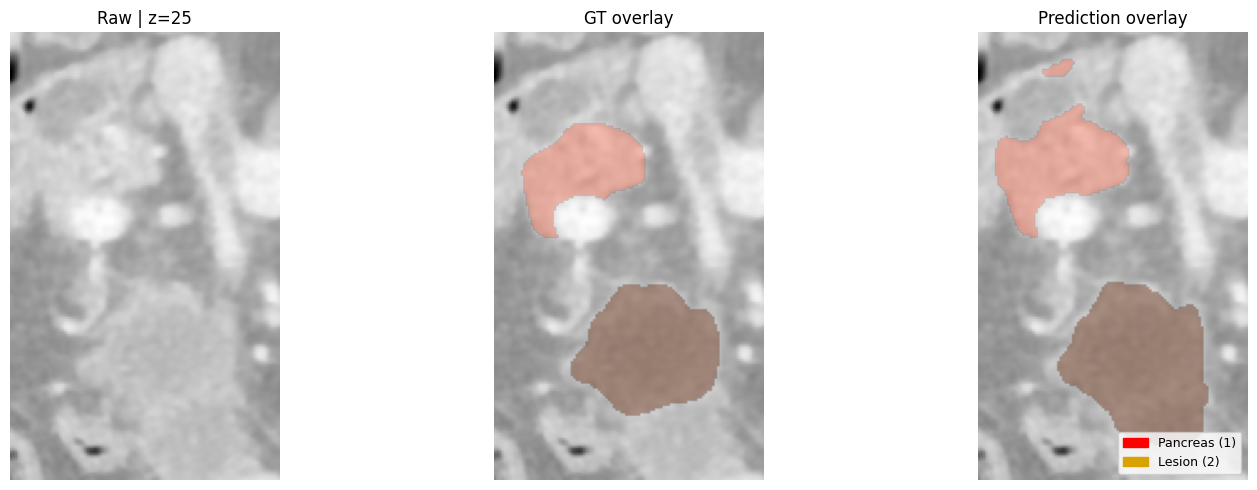

In [32]:
# === 3-panel overlays with printed file paths (supports PRED_VAL root OR a specific subtype folder) ===
import numpy as np, nibabel as nib, matplotlib.pyplot as plt
from pathlib import Path
from nibabel.processing import resample_from_to
from matplotlib.patches import Patch

# ---- config ----
DATA_VAL = Path("/workspace/Data/validation")
PRED_VAL = Path("/workspace/inference_results/val_preds/subtype0")  # root OR subtype folder is fine
CASE = "quiz_0_184"   # e.g. "quiz_1_093"; None = auto-pick first common
SLICE = None          # None = mid slice; or set an int
ALPHA = 0.40          # overlay transparency (0..1)

# ---- helpers ----
def _base_name(name: str) -> str:
    if name.endswith(".nii.nii.gz"): return name[:-11]
    if name.endswith(".nii.gz"):     return name[:-7]
    if name.endswith(".nii"):        return name[:-4]
    return name

def _pred_path_for(case: str, pdir: Path):
    p1, p2 = pdir / f"{case}.nii.gz", pdir / f"{case}.nii.nii.gz"
    return p1 if p1.exists() else (p2 if p2.exists() else None)

def _pred_dir_for_subtype(s: int, pred_root: Path):
    """
    If pred_root has subtype subfolders, return pred_root/subtype{s}.
    If pred_root itself IS a subtype folder matching s, return pred_root.
    Otherwise return None.
    """
    # case 1: pred_root contains subtype folders
    if (pred_root / f"subtype{s}").exists():
        return pred_root / f"subtype{s}"
    # case 2: pred_root itself is a subtype folder
    if pred_root.name == f"subtype{s}":
        return pred_root
    return None

def find_paths(case=None):
    # search across subtypes but tolerate PRED_VAL being either root or already a subtype folder
    if case is None:
        for s in (0,1,2):
            gdir = DATA_VAL / f"subtype{s}"
            pdir = _pred_dir_for_subtype(s, PRED_VAL)
            if pdir is None or not gdir.exists() or not pdir.exists():
                continue
            gt_cases = {_base_name(p.name) for p in gdir.glob("*.nii.gz") if not p.name.endswith("_0000.nii.gz")}
            pr_cases = {_base_name(p.name) for p in pdir.glob("*.nii*gz")}
            commons = sorted(gt_cases & pr_cases)
            if commons:
                c = commons[0]
                gi, gg, pp = gdir/f"{c}_0000.nii.gz", gdir/f"{c}.nii.gz", _pred_path_for(c, pdir)
                if pp is not None: return c, gi, gg, pp
        raise FileNotFoundError(f"No common cases found under predictions root: {PRED_VAL}")
    else:
        # specific case provided
        for s in (0,1,2):
            gdir = DATA_VAL / f"subtype{s}"
            pdir = _pred_dir_for_subtype(s, PRED_VAL)
            if pdir is None:
                continue
            gi, gg, pp = gdir/f"{case}_0000.nii.gz", gdir/f"{case}.nii.gz", _pred_path_for(case, pdir)
            if gi.exists() and gg.exists() and pp is not None:
                return case, gi, gg, pp
        raise FileNotFoundError(f"Case {case} not found under predictions root: {PRED_VAL}")

# ---- load ----
case_id, img_path, gt_path, pred_path = find_paths(CASE)

print(f"\nLoaded case: {case_id}")
print(f"  RAW  : {img_path}")
print(f"  GT   : {gt_path}")
print(f"  PRED : {pred_path}\n")

img  = nib.load(str(img_path))
gt   = nib.load(str(gt_path))
pred = nib.load(str(pred_path))
if pred.shape != gt.shape or not np.allclose(pred.affine, gt.affine, atol=1e-3):
    pred = resample_from_to(pred, gt, order=0)

img_np = img.get_fdata().astype(np.float32)
gt_np  = gt.get_fdata().astype(int)
pr_np  = pred.get_fdata().astype(int)

# ---- slice ----
z = img_np.shape[2]//2 if SLICE is None else int(np.clip(SLICE, 0, img_np.shape[2]-1))

gt_pan = np.ma.masked_where(gt_np[:,:,z] != 1, gt_np[:,:,z])
gt_les = np.ma.masked_where(gt_np[:,:,z] != 2, gt_np[:,:,z])
pr_pan = np.ma.masked_where(pr_np[:,:,z] != 1, pr_np[:,:,z])
pr_les = np.ma.masked_where(pr_np[:,:,z] != 2, pr_np[:,:,z])

# ---- plots ----
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# raw
axes[0].imshow(img_np[:,:,z], cmap="gray")
axes[0].set_title(f"Raw | z={z}")
axes[0].axis("off")

# raw + GT
axes[1].imshow(img_np[:,:,z], cmap="gray")
axes[1].imshow(gt_pan, cmap="Reds",   alpha=ALPHA, vmin=0, vmax=2)
axes[1].imshow(gt_les, cmap="YlOrBr", alpha=ALPHA, vmin=0, vmax=2)
axes[1].set_title("GT overlay")
axes[1].axis("off")

# raw + Pred
axes[2].imshow(img_np[:,:,z], cmap="gray")
axes[2].imshow(pr_pan, cmap="Reds",   alpha=ALPHA, vmin=0, vmax=2)
axes[2].imshow(pr_les, cmap="YlOrBr", alpha=ALPHA, vmin=0, vmax=2)
axes[2].set_title("Prediction overlay")
axes[2].axis("off")

legend = [Patch(color='red', label='Pancreas (1)'),
          Patch(color='#d8a200', label='Lesion (2)')]
axes[2].legend(handles=legend, loc="lower right", fontsize=9, frameon=True)

plt.tight_layout(); plt.show()

In [ ]:
# Fullfilling the test result criteria/requirements (evaluating test data, saving its masks, and csv)

In [33]:
# === Final TEST inference + submission CSV (Names,Subtype) ===

import os, json, torch, torch.nn.functional as F
import numpy as np, nibabel as nib, pandas as pd
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import zoom as nd_zoom, label as cc_label

# ----- paths -----
PLANS_PATH = "/workspace/nnUNet_preprocessed/Dataset501_Pancreas/nnUNetResEncUNetMPlans.json"
CKPT_PATH  = "/workspace/nnUNet_results/Dataset501_Pancreas/TrainerWithClassification__nnUNetResEncUNetMPlans__3d_fullres/fold_0/checkpoint_best.pth"

DATA_TEST  = Path("/workspace/Data/test")                       # <— flat folder with *_0000.nii.gz
OUT_TEST   = Path("/workspace/inference_results/test_preds")    # <— flat outputs
OUT_TEST.mkdir(parents=True, exist_ok=True)

# ----- load plans -----
with open(PLANS_PATH, "r") as f:
    plans = json.load(f)
cfg = plans["configurations"]["3d_fullres"]
patch_size     = tuple(int(x) for x in cfg["patch_size"])            # (Z,Y,X)
target_spacing = tuple(float(x) for x in cfg["spacing"])             # (Z,Y,X)
props = plans.get("foreground_intensity_properties_per_channel", {}).get("0", {})
CT_MEAN = float(props.get("mean", 0.0))
CT_STD  = float(props.get("std",  1.0))
P005    = float(props.get("percentile_00_5", -1000.0))
P995    = float(props.get("percentile_99_5",  1000.0))
ak = cfg["architecture"]["arch_kwargs"]

# ----- build model -----
import sys
sys.path.append('/workspace/nnUNet/nnunetv2/training/nnUNetTrainer')
from trainer_with_classification import SegClsUNet
from dynamic_network_architectures.architectures.unet import ResidualEncoderUNet

base = ResidualEncoderUNet(
    input_channels=1,
    n_stages=ak['n_stages'],
    features_per_stage=ak['features_per_stage'],
    conv_op=torch.nn.Conv3d,
    kernel_sizes=ak['kernel_sizes'],
    strides=ak['strides'],
    n_blocks_per_stage=ak['n_blocks_per_stage'],
    n_conv_per_stage_decoder=ak['n_conv_per_stage_decoder'],
    conv_bias=True,
    norm_op=torch.nn.InstanceNorm3d, norm_op_kwargs={'eps':1e-5,'affine':True},
    dropout_op=None,
    nonlin=torch.nn.LeakyReLU, nonlin_kwargs={'inplace':True},
    deep_supervision=True, num_classes=3
)
model = SegClsUNet(base_unet=base, n_classes_cls=3)

state = torch.load(CKPT_PATH, map_location='cpu', weights_only=False)
model.load_state_dict(state['network_weights'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()
print("Using device:", device)

# ----- helpers -----
def _compute_padding(orig, tile, stride):
    need = max(orig, tile); r = (need - tile) % stride
    extra = 0 if r == 0 else (stride - r)
    tot = (need + extra) - orig
    L = tot // 2; R = tot - L
    return L, R

def _pad3d(x, tile, stride):
    _,_,D,H,W = x.shape
    pd0,pd1 = _compute_padding(D, tile[0], stride[0])
    ph0,ph1 = _compute_padding(H, tile[1], stride[1])
    pw0,pw1 = _compute_padding(W, tile[2], stride[2])
    return F.pad(x, (pw0,pw1,ph0,ph1,pd0,pd1), mode='replicate'), (pd0,pd1,ph0,ph1,pw0,pw1)

def _uncrop(x, p):
    _,_,D,H,W = x.shape
    pd0,pd1,ph0,ph1,pw0,pw1 = p
    return x[:, :, pd0:D-pd1 if pd1>0 else D, ph0:H-ph1 if ph1>0 else H, pw0:W-pw1 if pw1>0 else W]

def _gwin(tile):
    def g1(n):
        z = np.linspace(-1, 1, n)
        return np.exp(-(z**2)*4.0)
    wz, wy, wx = map(g1, tile)
    w = wz[:,None,None] * wy[None,:,None] * wx[None,None,:]
    w = w / w.max()
    return torch.from_numpy(w.astype(np.float32))

def ct_norm_from_plans(x):
    x = np.clip(x, P005, P995)
    return ((x - CT_MEAN) / (CT_STD + 1e-8)).astype(np.float32)

def zoom_anisotropic_zyx(vol_zyx, zf_zyx, order_z=0, order_xy=3):
    if zf_zyx[0] != 1.0:
        vol_zyx = nd_zoom(vol_zyx, (zf_zyx[0], 1.0, 1.0), order=order_z)
    if zf_zyx[1] != 1.0 or zf_zyx[2] != 1.0:
        vol_zyx = nd_zoom(vol_zyx, (1.0, zf_zyx[1], zf_zyx[2]), order=order_xy)
    return vol_zyx

@torch.inference_mode()
def infer_tiled_tta(img4d, tile, stride):
    flips = [(0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(0,1,1),(1,1,1)]
    x0, pad = _pad3d(img4d, tile, stride)
    _,_,Dp,Hp,Wp = x0.shape
    d0,h0,w0 = min(tile[0],Dp),min(tile[1],Hp),min(tile[2],Wp)
    probe,_ = model(x0[:,:,:d0,:h0,:w0])
    if isinstance(probe, list): probe = probe[0]
    C = probe.shape[1]
    w3d = _gwin(tile).to(device)
    seg_sum = None
    cls_max = None

    for fz,fy,fx in flips:
        x = img4d
        if fz: x = torch.flip(x, dims=[2])
        if fy: x = torch.flip(x, dims=[3])
        if fx: x = torch.flip(x, dims=[4])

        x_pad, pad = _pad3d(x, tile, stride)
        seg_acc = torch.zeros((1,C,Dp,Hp,Wp), device=device)
        w_acc   = torch.zeros((1,1,Dp,Hp,Wp), device=device)

        for z in range(0, Dp - tile[0] + 1, stride[0]):
            for y in range(0, Hp - tile[1] + 1, stride[1]):
                for x_ in range(0, Wp - tile[2] + 1, stride[2]):
                    patch = x_pad[:, :, z:z+tile[0], y:y+tile[1], x_:x_+tile[2]]
                    seg, cls = model(patch)
                    if isinstance(seg, list): seg = seg[0]
                    seg_acc[:, :, z:z+tile[0], y:y+tile[1], x_:x_+tile[2]] += seg * w3d
                    w_acc  [:, :, z:z+tile[0], y:y+tile[1], x_:x_+tile[2]] += w3d
                    cls_max = cls if cls_max is None else torch.maximum(cls_max, cls)

        seg_logits = seg_acc / torch.clamp_min(w_acc, 1e-6)
        seg_logits = _uncrop(seg_logits, pad)
        if fx: seg_logits = torch.flip(seg_logits, dims=[4])
        if fy: seg_logits = torch.flip(seg_logits, dims=[3])
        if fz: seg_logits = torch.flip(seg_logits, dims=[2])
        seg_sum = seg_logits if seg_sum is None else (seg_sum + seg_logits)

    seg_avg = seg_sum / len(flips)
    return seg_avg, cls_max

def largest_component_foreground(seg_xyz):
    fg = (seg_xyz > 0).astype(np.uint8)
    if not fg.any(): return seg_xyz
    cc, n = cc_label(fg)
    if n <= 1: return seg_xyz
    sizes = [(cc == i).sum() for i in range(1, n+1)]
    keep = 1 + int(np.argmax(sizes))
    seg_xyz[(cc != keep) & (fg == 1)] = 0
    return seg_xyz

# ----- collect test files -----
test_imgs = sorted(DATA_TEST.glob("*_0000.nii.gz"))
print(f"Found {len(test_imgs)} test cases in {DATA_TEST}")

# ----- inference -----
tile   = patch_size
stride = tuple(max(1, s//3) for s in tile)

rows = []
for ip in tqdm(test_imgs, desc="TEST"):
    nii = nib.load(str(ip))
    img_xyz = nii.get_fdata().astype(np.float32)
    zoom_xyz = nii.header.get_zooms()[:3]

    # to ZYX and resample
    img_zyx  = np.transpose(img_xyz, (2,1,0))
    zoom_zyx = (zoom_xyz[2], zoom_xyz[1], zoom_xyz[0])
    zf_zyx   = tuple(zoom_zyx[i] / target_spacing[i] for i in range(3))
    img_rs_zyx = zoom_anisotropic_zyx(img_zyx, zf_zyx, order_z=0, order_xy=3)

    # normalize
    img_rs_zyx = ct_norm_from_plans(img_rs_zyx)

    # inference (TTA + blending)
    t = torch.from_numpy(img_rs_zyx)[None,None].to(device)
    seg_logits_rs, cls_logits = infer_tiled_tta(t, tile, stride)
    seg_soft = torch.softmax(seg_logits_rs, dim=1)
    seg_rs_zyx = torch.argmax(seg_soft, dim=1).squeeze(0).detach().cpu().numpy().astype(np.int16)

    # back to original spacing & axes
    seg_orig_zyx = zoom_anisotropic_zyx(seg_rs_zyx, tuple(1.0/z for z in zf_zyx), order_z=0, order_xy=0).astype(np.int16)
    seg_orig_xyz = np.transpose(seg_orig_zyx, (2,1,0))

    # LCC
    seg_orig_xyz = largest_component_foreground(seg_orig_xyz)

    # save seg + json
    case = ip.stem.replace("_0000","")
    out_seg = OUT_TEST / f"{case}.nii.gz"
    nib.save(nib.Nifti1Image(seg_orig_xyz, nii.affine, nii.header), str(out_seg))

    cp = torch.softmax(cls_logits, dim=1).squeeze(0).detach().cpu().numpy()
    pred_cls = int(np.argmax(cp))
    out_json = OUT_TEST / f"{case}_classification.json"
    with open(out_json, "w") as f:
        json.dump({
            "case": case,
            "predicted_subtype": pred_cls,
            "confidence": float(cp[pred_cls]),
            "probabilities": {"subtype_0": float(cp[0]), "subtype_1": float(cp[1]), "subtype_2": float(cp[2])}
        }, f, indent=2)

    rows.append({"Names": f"{case}.nii.gz", "Subtype": pred_cls})

# ----- submission CSV -----
sub_csv = OUT_TEST / "subtype_results.csv"
pd.DataFrame(rows).sort_values("Names").to_csv(sub_csv, index=False)
print(f"\nInference complete. Saved {len(rows)} cases to {OUT_TEST}")
print(f"Submission CSV written to: {sub_csv}")


Using device: cuda
Found 72 test cases in /workspace/Data/test


TEST: 100%|██████████| 72/72 [05:27<00:00,  4.55s/it]


Inference complete. Saved 72 cases to /workspace/inference_results/test_preds
Submission CSV written to: /workspace/inference_results/test_preds/subtype_results.csv


Loaded test case: quiz_037
  RAW : /workspace/Data/test/quiz_037_0000.nii.gz
  PRED: /workspace/inference_results/test_preds/quiz_037.nii.nii.gz


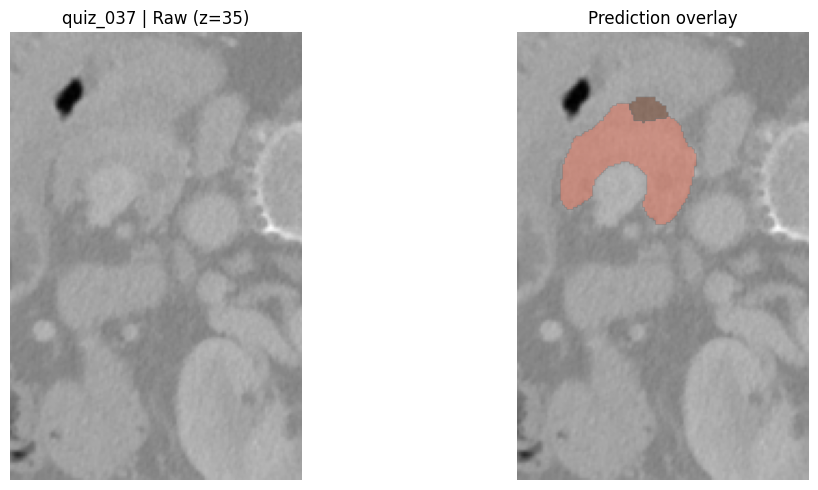

In [34]:
import numpy as np, nibabel as nib, matplotlib.pyplot as plt
from pathlib import Path
from nibabel.processing import resample_from_to

DATA_TEST = Path("/workspace/Data/test")                 # flat
PRED_TEST = Path("/workspace/inference_results/test_preds")  # flat
CASE = None   # e.g. "quiz_1_093"; None = auto-pick first common
SLICE = None
ALPHA = 0.4

def base_raw(name: str) -> str:
    s = name
    if s.endswith(".nii.gz"): s = s[:-7]
    if s.endswith(".nii"):    s = s[:-4]
    if s.endswith("_0000"):   s = s[:-5]
    return s

def base_pred(name: str) -> str:
    s = name
    if s.endswith(".nii.nii.gz"): s = s[:-11]
    elif s.endswith(".nii.gz"):   s = s[:-7]
    elif s.endswith(".nii"):      s = s[:-4]
    return s

# collect
raw_map = {base_raw(p.name): p for p in DATA_TEST.glob("*_0000.nii.gz")}
pred_map = {base_pred(p.name): p for p in PRED_TEST.glob("*.nii*gz")}

# choose case
if CASE is None:
    commons = sorted(set(raw_map) & set(pred_map))
    if not commons:
        raise FileNotFoundError("No common cases between test raws and preds. Run the debug cell and pick a CASE that exists in both.")
    CASE = commons[0]
else:
    if CASE not in raw_map or CASE not in pred_map:
        raise FileNotFoundError(f"CASE '{CASE}' not found in both. Exists in raw: {CASE in raw_map}, in pred: {CASE in pred_map}")

img_path, pred_path = raw_map[CASE], pred_map[CASE]
print(f"Loaded test case: {CASE}\n  RAW : {img_path}\n  PRED: {pred_path}")

# load and align
img_nii  = nib.load(str(img_path))
pred_nii = nib.load(str(pred_path))
if pred_nii.shape != img_nii.shape or not np.allclose(pred_nii.affine, img_nii.affine, atol=1e-3):
    pred_nii = resample_from_to(pred_nii, img_nii, order=0)

img = img_nii.get_fdata().astype(np.float32)
pr  = pred_nii.get_fdata().astype(np.int16)

z = img.shape[2]//2 if SLICE is None else int(np.clip(SLICE, 0, img.shape[2]-1))
pr_pan = np.ma.masked_where(pr[:,:,z] != 1, pr[:,:,z])
pr_les = np.ma.masked_where(pr[:,:,z] != 2, pr[:,:,z])

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].imshow(img[:,:,z], cmap="gray"); axes[0].set_title(f"{CASE} | Raw (z={z})"); axes[0].axis("off")
axes[1].imshow(img[:,:,z], cmap="gray")
axes[1].imshow(pr_pan, cmap="Reds", alpha=ALPHA, vmin=0, vmax=2)
axes[1].imshow(pr_les, cmap="YlOrBr", alpha=ALPHA, vmin=0, vmax=2)
axes[1].set_title("Prediction overlay"); axes[1].axis("off")
plt.tight_layout(); plt.show()


In [ ]:
# !pip freeze > requirements.txt

In [ ]:
# !head requirements.txt

In [ ]:
# !pwd

In [ ]:
# !ls -R | grep requirements.txt

In [ ]:
# !ls -lh requirements.txt